# Laboratorio 3: Calculo de ganancia y ruido de lectura

In [190]:
from glob import glob
from astropy.io import fits

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from scipy.optimize import curve_fit
import pandas as pd
import copy
import itertools
import math

In [188]:
files = glob('Data_1103/*.fit')

In [189]:
BIAS = []
FLATS = {}

for file in files:
    Flats_files.append(file)
    
    if 'bias' in file:
        BIAS.append(fits.getdata(file))
        
    else:
        name = file.replace('Data_1103\\', '')[:-5]
        if name in FLATS:
            FLATS[name].append(fits.getdata(file))
        else: 
            FLATS[name] = []
            FLATS[name].append(fits.getdata(file))
    
bias_median = np.median(np.array(BIAS), axis=0)   
stddiffb1b2 = np.std(BIAS[0].astype("float64") - BIAS[1].astype("float64"))

In [182]:
flats_files = copy.deepcopy(FLATS)

for file in flats_files.keys():
    flat_list = flats_files[file]
    flats12_median = np.median(np.array(flat_list[:2]), axis=0) 
    flats34_median = np.median(np.array(flat_list[2:4]), axis=0) 
    
    flats_files[file] = [flats12_median.astype("float64")  - bias_median.astype("float64") , flats34_median.astype("float64")  - bias_median.astype("float64") ]

In [183]:
def calc_summed_flats(flats:list):
    summed_flats = (flats[0] + flats[1]) / 2
    return summed_flats

In [184]:
def calc_diff_flats(flats:list):
    diff_flats = flats[0] - flats[1]
    return diff_flats

In [185]:
def quantile_imshow(img,lower=0.01,upper=0.99,**kwargs):
    img_vmin = np.quantile(img,lower)
    img_vmax = np.quantile(img,upper)
    return plt.imshow(img,vmin=img_vmin,vmax=img_vmax,**kwargs)

In [186]:
combs = itertools.combinations(flats_files.keys(), 3)
flats_pairs = {}

for files in combs:
    name = f'{files[0]}_{files[1]}_{files[2]}'
    
    flats_info = {f'{files[0]}_pair': flats_files[files[0]],
                  f'{files[1]}_pair': flats_files[files[1]],
                  f'{files[2]}_pair': flats_files[files[2]],
                  f'{files[0]}_summed': calc_summed_flats(flats_files[files[0]]),
                  f'{files[1]}_summed': calc_summed_flats(flats_files[files[1]]),
                  f'{files[2]}_summed': calc_summed_flats(flats_files[files[2]]),
                  f'{files[0]}_diff': calc_diff_flats(flats_files[files[0]]),
                  f'{files[1]}_diff': calc_diff_flats(flats_files[files[1]]),
                  f'{files[2]}_diff': calc_diff_flats(flats_files[files[2]])}
    
    flats_pairs[name] = flats_info  

In [171]:
def calc_mean_level(summed_flat):
    x_min, y_min = 50, 50 
    x_max, y_max = 150, 150
    
    area = summed_flat[y_min:y_max, x_min:x_max]
    mean_level = np.mean(area)
    return mean_level
    

In [172]:
def linear_function(x, m, b):
    return m * x + b

In [173]:
def calc_variance(diff_flats):
    x_min, y_min = 50, 50 
    x_max, y_max = 150, 150
    
    area_difference = diff_flats[y_min:y_max, x_min:x_max]  
    rms = np.std(area_difference)
    
    var = (rms)**2 / 2
    return var
    

In [191]:
variance_rms_flats = {}

for files in flats_pairs.keys():
    flats_fil = files.split('_')
    flat_pair_1 = flats_fil[0]; flat_pair_2 = flats_fil[1]; flat_pair_3 = flats_fil[2]
    
    flats = flats_pairs[files]
    
    variance = [calc_variance(flats[f'{flat_pair_1}_diff']), 
                calc_variance(flats[f'{flat_pair_2}_diff']), 
                calc_variance(flats[f'{flat_pair_3}_diff'])]
    
    mean_level = [calc_mean_level(flats[f'{flat_pair_1}_summed']),
                  calc_mean_level(flats[f'{flat_pair_2}_summed']),
                  calc_mean_level(flats[f'{flat_pair_3}_summed'])]
    
    params, covariance = curve_fit(linear_function, mean_level, variance)
    
    gain = 1/params[0]
    
    read_noise = (gain * stddiffb1b2) / math.sqrt(2)
    
    variance_rms_flats[files] = {'variance': variance,
                                 'mean_level': mean_level,
                                 'gain':gain,
                                 'read_noise': read_noise}


In [200]:
gains = []
read_noise = []

for line in variance_rms_flats.keys():
    gains.append(variance_rms_flats[line]["gain"])
    read_noise.append(variance_rms_flats[line]["read_noise"])

gain_mean = np.median(gains)
read_noise_mean = np.median(read_noise)

In [201]:
print(f'El valor encontrado para la ganancia es de: {gain_mean}')
print(f'El valor encontrado para el ruido de lectura es de: {read_noise_mean}')

El valor encontrado para la ganancia es de: 3.1123029028319804
El valor encontrado para el ruido de lectura es de: 38.034917299550166


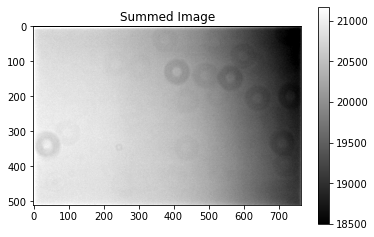

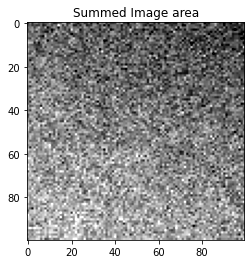

In [193]:
#ejemplo de prueba
flats_test = flats_pairs['FLAT004_FLAT006_FLAT009']['FLAT009_summed']
flats_test2 = flats_pairs['FLAT004_FLAT006_FLAT009']['FLAT009_diff']

quantile_imshow(flats_test, cmap='gray')
plt.title('Summed Image')
plt.colorbar()
plt.savefig('summed.jpg')
plt.show()

x_min, y_min = 50, 50 
x_max, y_max = 150, 150

area = flats_test[y_min:y_max, x_min:x_max]
quantile_imshow(area, cmap='gray')
plt.title('Summed Image area')
plt.savefig('area_summed.jpg')
mean_level = np.mean(area)

area_difference = flats_test2[y_min:y_max, x_min:x_max]  
std_dev = np.std(area_difference)

var = (std_dev)**2 / 2